# SimiC Pipeline - Full Tutorial

>*Author: Irene Marín-Goñi, PhD student - ML4BM group (CIMA University of Navarra)*

This notebook provides a comprehensive guide to how to use the new SimiC pipeline with all available features.


## Overview
This tutorial covers:
1. Package installation and set up
2. Complete pipeline initialization with all parameters
3. Running the full pipeline with filtering and AUC calculation steps
4. Follow up steps: Detailed results analysis
5. Analyze previous runs
6. Cross-validation and parameter sweeps

For a simpler introduction, see `Tutorial_SimiCPipeline_simple.ipynb`

## Introduction
SimiC is a GRN inference algorithm for scRNA-Seq data that takes as input i) single-cell imputed expression data, ii) a list of driver genes, iii) the cell labels (cell phenotypes in order), and produces a TF-specific GRNs for each of the different phenotypes. Given the phenotype order, SimiC adds a similarity constraint when jointly inferring the GRNs for each phenotype, ensuring a smooth transition across phenotypes.

For more information check our publication:

Peng, J., Serrano, G., Traniello, I.M. et al. SimiC enables the inference of complex gene regulatory dynamics across cell phenotypes. Commun Biol 5, 351 (2022). https://doi.org/10.1038/s42003-022-03319-7


## Setup

The easiest way to configure your environment is to follow the `README` instructions using `poetry` (or `Docker`).


Required packages for this tutorial:
- simicpipeline
- anndata
- pandas
- numpy
- os
- pickle

Internally simicpipeline also uses:
- sklearn

We recommend preprocessing the data and set up the directory structure following the `Tutorial_SimiCPipeline_preprocessing.poynb`



## Pipeline steps

First, import the necessary modules and set up the path.

In [1]:
import os
print(os.getcwd())
os.chdir("/mnt/md0/imaring/test/")
print(os.getcwd())
os.listdir(".")

/mnt/md0/imaring/SimiCPipeline
/mnt/md0/imaring/test


['experiment1_L1_0.1_L2_0.01_simic_matrices_hola',
 'SimiCExampleRun',
 'data',
 'SimicExampleRun2']

In [2]:
import simicpipeline
simicpipeline.__version__

'0.1.0'

In [3]:
from simicpipeline import SimiCPipeline

### Step 1: Initialize the Pipeline

Create a pipeline instance by specifying:
- `project_dir`: Working directory path where input files are located and output files will be saved
- `run_name`: Unique identifier for this analysis run (used as prefix for output files)

In [4]:
print("Initializing SimiC pipeline")
pipeline = SimiCPipeline(
    project_dir="./SimiCExampleRun/KPB25L/Tumor",
    run_name="experiment_tumor"
)

print(f"Pipeline initialized with workdir: {pipeline.project_dir}")

Initializing SimiC pipeline
Pipeline initialized with workdir: SimiCExampleRun/KPB25L/Tumor


### Step 2: Set Input File Paths

Point the pipeline to your input files:
- `p2df`: Path to expression matrix file (genes × cells) stored as a pandas DataFrame in pickle format
- `p2assignment`: Path to cell cluster assignment file (.txt format) containing phenotype labels as integers matching expression matrix cell order
- `p2tf`: Path to transcription factor list file (pickle format) containing TF gene names to use as drivers

In [5]:
print("Setting input file paths")
pipeline.set_input_paths(
    p2df = pipeline.project_dir / "inputFiles/expression_matrix.pickle",
    p2assignment = pipeline.project_dir / "inputFiles/treatment_annotation.txt",
    p2tf = pipeline.project_dir / "inputFiles/TF_list.pickle"
)


Setting input file paths


### Step 3: Set Parameters

Set all available parameters for the SimiC regression:

#### Core Regularization Parameters:
- `lambda1`: L1 regularization strength controlling sparsity in the learned networks (higher values $\approx $ sparser networks with fewer edges, default: $1e^{-1}$)
- `lambda2`: L2 regularization strength controlling similarity between adjacent phenotype networks (higher values $\approx $ more similar networks across phenotypes, default: $1e^{-5}$)
- `similarity`: Boolean flag to enable similarity-based clustering when inferring GRNs (default: `True`)

#### Algorithm Parameters:
- `max_rcd_iter`: Maximum number of iterations for the coordinate descent optimization algorithm (default: 50000)

<div class="alert alert-block alert-danger">
<b> Important note:</b> This parameter controls the number of iterations of the algorithm and will strongly influence the time it takes to run
</div>

#### Clustering Parameters:
- `k_cluster`: Number of clusters to create if not using a pre-defined assignment file (None: using assignment file, integer: number of clusters)
- `numIter`: Maximum number of iterations of the k-means algorithm.

#### Cross-Validation Parameters:
- `cross_val`: Boolean flag to enable cross-validation for automatic parameter selection (default: False)
- `k_cross_val`: Integer for the number of folds for cross-validation (default: 5)
- `max_rcd_iter_cv`: SImilar to `max_rcd_iter`. To speed up the process the default value is 10000. 
- `list_of_l1`: List of lambda1 values to test during cross-validation (e.g., [10, 1, 1e-1, 1e-2, 1e-4])
- `list_of_l2`: List of lambda2 values to test during cross-validation (e.g., [1e-1, 1e-2, 1e-3, 1e-4, 1e-5])

In [ ]:
print("Setting custom parameters")
pipeline.set_parameters(
    lambda1=1e-1,
    lambda2=1e-2,
    similarity=True,
    max_rcd_iter=5000,
    k_cluster=None,
    cross_val=True,
    k_cross_val=4,
    max_rcd_iter_cv=1000,
    list_of_l1=[1e-1, 1e-2],  # Example: [10, 1, 1e-1, 1e-2, 1e-4]
    list_of_l2=[1e-2, 1e-3] # Example: [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
)

Setting custom parameters


<a id='step4'></a>
### Step 4: Configure AUC Calculation Parameters

<div class="alert alert-block alert-warning">
Except for `adj_r2_threshold` the other parameters are rarely used but are available in SimiC-Jianhao
</div>

Define parameters for Area Under Curve calculation which measures TF activity scores:
- `adj_r2_threshold`: Minimum adjusted R² value for filtering target genes based on regression quality (range: 0-1, typical: 0.7)
- `select_top_k_targets`: Number of top-ranked targets to include per TF (None: use all targets, integer: specific number)
- `percent_of_target`: Percentage of targets to include after ranking (range: 0-1, default: 1 for 100%)
- `sort_by`: Criterion for ranking and selecting targets ('expression': by mean expression level, 'weight': by network weight, 'adj_r2': by adjusted R² value)
- `num_cores`: Number of CPU cores to use for parallel processing (-1: use all available cores, positive integer: specific number, default: 1)

In [12]:
auc_params = {
    'adj_r2_threshold': 0.7,
    'select_top_k_targets': None,
    'percent_of_target': 1,
    'sort_by': 'expression',
    'num_cores': -2
}


Validate the inputs before run the pipeline

In [13]:
pipeline.validate_inputs()

✓ All required input files found


### Step 5: Run the Complete Pipeline

Executing the full pipeline in one command is easy with this implementation.

Steps incuded:
1. Input validation
2. SimiC regression
3. Weight filtering
4. AUC calculation

#### Custom Pipeline Execution Options:
- `skip_filtering`: If `True`, skips the weight filtering step that removes low-importance edges (default: False)
- `calculate_raw_auc`: If `True`, calculates AUC scores on unfiltered regression weights before any filtering (default: False)
- `calculate_filtered_auc`: If `True`, calculates AUC scores on filtered weights after removing noise (default: True)
- `variance_threshold`: Threshold for TF selection based on variance explained - keeps TFs explaining this cumulative percentage of target variance (range: 0-1, common value: 0.9 for 90%)
- `auc_params`: Dictionary containing all AUC calculation parameters as defined in [Step4](#step4)

In [16]:
print("Running complete SimiC pipeline...")
print("This may take several minutes depending on data size.\n")

pipeline.run_pipeline(
    skip_filtering=False,
    calculate_raw_auc=False,
    calculate_filtered_auc=True,
    variance_threshold=0.9,
    auc_params=auc_params
)

Running complete SimiC pipeline...
This may take several minutes depending on data size.


STARTING SIMIC PIPELINE
✓ All required input files found

Running SimiC Regression
Run name: experiment_tumor
✓ All required input files found
Running cross-validation with following lambdas: [0.1, 0.01] (L1), [0.01, 0.001] (L2)

------ Begin the regression part...
Expression matrix for regression shape =  (21490, 1100)
df test =  (4298, 1100)
test data assignment set: {0, 1, 2, 3}
df train =  (17192, 1100)
train data assignment set: {0, 1, 2, 3}
-------
-------
.... generating train set
cell type  0
	TF size: (3499, 101)
	Target size: (3499, 1000)
cell type  1
	TF size: (4747, 101)
	Target size: (4747, 1000)
cell type  2
	TF size: (3912, 101)
	Target size: (3912, 1000)
cell type  3
	TF size: (5034, 101)
	Target size: (5034, 1000)
-------
.... generating test set
cell type  0
	TF size: (893, 101)
	Target size: (893, 1000)
cell type  1
	TF size: (1148, 101)
	Target size: (1148, 1000)
cell type  2


In [17]:
pipeline.available_results()
# pipeline.calculate_auc(use_filtered = True)


Available Results:
✓ Ws_raw
✓ Ws_filtered
✗ auc_raw
✓ auc_filtered



In [18]:
pipeline._print_summary()


PIPELINE EXECUTION SUMMARY

Run name: experiment_tumor
Project directory: SimiCExampleRun/KPB25L/Tumor

Parameters:
  - Lambda1: 0.1
  - Lambda2: 0.01
  - Number of TFs: 100
  - Number of targets: 1000
  - Clusters: None

Timing:
  - simic_regression: 7min 55s
  - filtering: 26s
  - auc_filtered: 37min 52s
  - total: 46min 15s

Available Results:
✓ Ws_raw
✓ Ws_filtered
✗ auc_raw
✓ auc_filtered



<div class="alert alert-block alert-success">
<b>Success!</b>
</div>

## How to continue? 
### Check Available Results

View all results generated by the pipeline run.

In [19]:
pipeline.available_results()


Available Results:
✓ Ws_raw
✓ Ws_filtered
✗ auc_raw
✓ auc_filtered



### Analyze Weight Distribution

Generate summary statistics and visualizations of the learned weights.

In [20]:
pipeline.analyze_weights()


ANALYZING WEIGHT MATRICES

Label 0:
  Raw weights:
    - Sparsity: 0.00%
    - Avg non-zero TFs per target: 100.00
  Filtered weights:
    - Sparsity: 83.93%
    - Avg non-zero TFs per target: 16.07
  Reduction: 83.93% more sparse

Label 1:
  Raw weights:
    - Sparsity: 0.00%
    - Avg non-zero TFs per target: 100.00
  Filtered weights:
    - Sparsity: 82.40%
    - Avg non-zero TFs per target: 17.60
  Reduction: 82.40% more sparse

Label 2:
  Raw weights:
    - Sparsity: 0.00%
    - Avg non-zero TFs per target: 100.00
  Filtered weights:
    - Sparsity: 81.96%
    - Avg non-zero TFs per target: 18.04
  Reduction: 81.96% more sparse

Label 3:
  Raw weights:
    - Sparsity: 0.00%
    - Avg non-zero TFs per target: 100.00
  Filtered weights:
    - Sparsity: 82.34%
    - Avg non-zero TFs per target: 17.66
  Reduction: 82.34% more sparse



### Analyze AUC Scores

Examine the distribution of TF-target predicted activity scores via AUC.

In [50]:
auc_dic = pipeline.load_results('auc_filtered')
print(auc_dic.keys())
auc_dic[0].shape

dict_keys([0, 1, 2, 3])


(21490, 100)

<div class="alert alert-block alert-warning">
Note that each key in teh dictionary corresponds to a label in the data but the output AUC matrices have values for all the cells (original_matrix shape)
</div>

You need to subset the AUC matrix to get only the cells corresponding to that label. 


For that we have the following hansy function:


In [60]:
auc_subset = pipeline.subset_label_specific_auc('auc_filtered',label=0)
print(auc_subset.shape)
# auc_subset

(4392, 100)


In [61]:
# pipeline.analyze_auc_scores()

### Calculate Dissimilarity Scores

Compute dissimilar regulons between phenotype populations.

#### All Labels

In [ ]:
print("----> For all labels:")

MinMax_all = pipeline.calculate_dissimilarity()
print(f"\nDissimilarity matrix shape: {MinMax_all.shape}")


#### Specific Labels

Calculate dissimilarity between selected populations only.
- `select_labels`: List of integer labels to include in dissimilarity calculation (e.g., [0, 3] for comparing populations 0 and 3)

In [ ]:
print("----> For labels 0 and 3:")

MinMax_0_3 = pipeline.calculate_dissimilarity(select_labels=[0, 3])

## Load and Inspect Results
### Load Filtered Weights

Access the filtered weight matrices for downstream analysis.

In [ ]:
print("="*70)
print("Accessing filtered weights...\n")

simic_results = pipeline.load_results('Ws_filtered')
print(f"SimiC results keys: {list(simic_results.keys())}")

weight_dic = simic_results['weight_dic']
print(f"\nWeight dictionary keys (labels): {list(weight_dic.keys())}")
print(f"Number of cell populations: {len(weight_dic)}")

# Inspect first population
first_label = list(weight_dic.keys())[0]
first_weights = weight_dic[first_label]
print(f"\nWeight matrix for label {first_label}:")
print(f"  Shape: {first_weights.shape}")
print(f"  Non-zero entries: {(first_weights != 0).sum()}")

### Load Filtered AUC Scores

Examine the filtered AUC scores across all cell populations.

In [ ]:
print("="*70)
print("Accessing filtered AUC scores...\n")

auc_filtered = pipeline.load_results('auc_filtered')
print(f"AUC dictionary keys (labels): {list(auc_filtered.keys())}")
print(f"Number of cell populations: {len(auc_filtered)}")

# Inspect first population
first_auc = list(auc_filtered.values())[0]
print(f"\nAUC matrix shape: {first_auc.shape}")
print(f"Mean AUC: {first_auc.mean().mean():.3f}")

### Extract Label-Specific AUC Scores

Get AUC scores for a specific cell population/phenotype.
- `result_type`: Name of the AUC results to load ('auc_raw' for unfiltered or 'auc_filtered' for filtered weights)
- `label`: Integer specifying which cell phenotype/population to extract (must match labels in assignment file)

In [ ]:
# Extract for label 3
auc_3 = pipeline.subset_label_specific_auc('auc_filtered', label=3)
print(f"AUC for label 3:")
print(f"  Shape: {auc_3.shape}")
print(f"  Mean: {auc_3.mean().mean():.3f}")
print(f"\nFirst 5 rows and columns:")
print(auc_3.iloc[0:5, 0:5])

## Extract TF-Specific Networks

Get the regulatory network for specific transcription factors.
- `TF_name`: Name of the transcription factor gene (must be present in the TF list provided to the pipeline)
- `stacked`: If True, returns a pandas DataFrame with GRN weights for all labels in separate columns; if False, returns a dictionary of separate pandas Series per label

In [ ]:
# Example: Get network for Bnc2
tf_name = "Bnc2"
network = pipeline.get_TF_network(tf_name, stacked=True)

print(f"Network for {tf_name}:")
print(f"  Shape: {network.shape}")
print(f"  Columns: {list(network.columns)}")
print(f"\nTop 10 targets:")
print(network.head(10))

## Visualization Examples

Create visualizations for better understanding of results.


### Visualize Weight Distributions

Create visualizations for R² distributions and weight analysis.

In [ ]:
# Import visualization class
from simicpipeline import SimiCVisualization

# Create visualization object from pipeline
viz = SimiCVisualization(
    project_dir=pipeline.project_dir,
    run_name=pipeline.run_name,
    n_tfs=pipeline.n_tfs,
    n_targets=pipeline.n_targets
)

# Copy paths from pipeline
viz.set_paths_custom(
    p2df=pipeline.p2df,
    p2assignment=pipeline.p2assignment,
    p2tf=pipeline.p2tf,
    p2simic_matrices=pipeline.p2filtered_matrices,
    p2filtered_matrices=pipeline.p2filtered_matrices,
    p2auc_raw=pipeline.p2auc_raw,
    p2auc_filtered=pipeline.p2auc_filtered
)

# # Set custom label names
# viz.set_label_names({
#     0: 'Control',
#     1: 'PD-L1',
#     2: 'DAC',
#     3: 'Combination'
# })

# # Plot R² distributions
# fig = viz.plot_r2_distribution(save=False)
# print("\nR² distribution plot created successfully!")


### TF Weight Barplots

Visualize regulatory weights for specific transcription factors.

In [58]:
# Get top TFs by dissimilarity score
top_tfs = MinMax_all.head(5).index.tolist()
print(f"Top 5 TFs by dissimilarity: {top_tfs}")

# Plot TF weights for top TFs
fig = viz.plot_tf_weights(
    tf_names=top_tfs,
    top_n_targets=30,
    save=True
)
print("\nTF weight barplots created successfully!")

Top 5 TFs by dissimilarity: ['Nfat5', 'Glis3', 'Zfpm2', 'Esr1', 'Tcf7l2']


NameError: name 'viz' is not defined

### Target Gene Weight Barplots

Visualize which TFs regulate specific target genes.


PLOTTING TARGET WEIGHT BARPLOTS

Processing Egfr...
Processing Pdgfra...
✓ Saved to SimiCExampleRun/outputSimic/figures/experiment1/experiment1_target_weights.pdf

Target weight barplots created successfully!


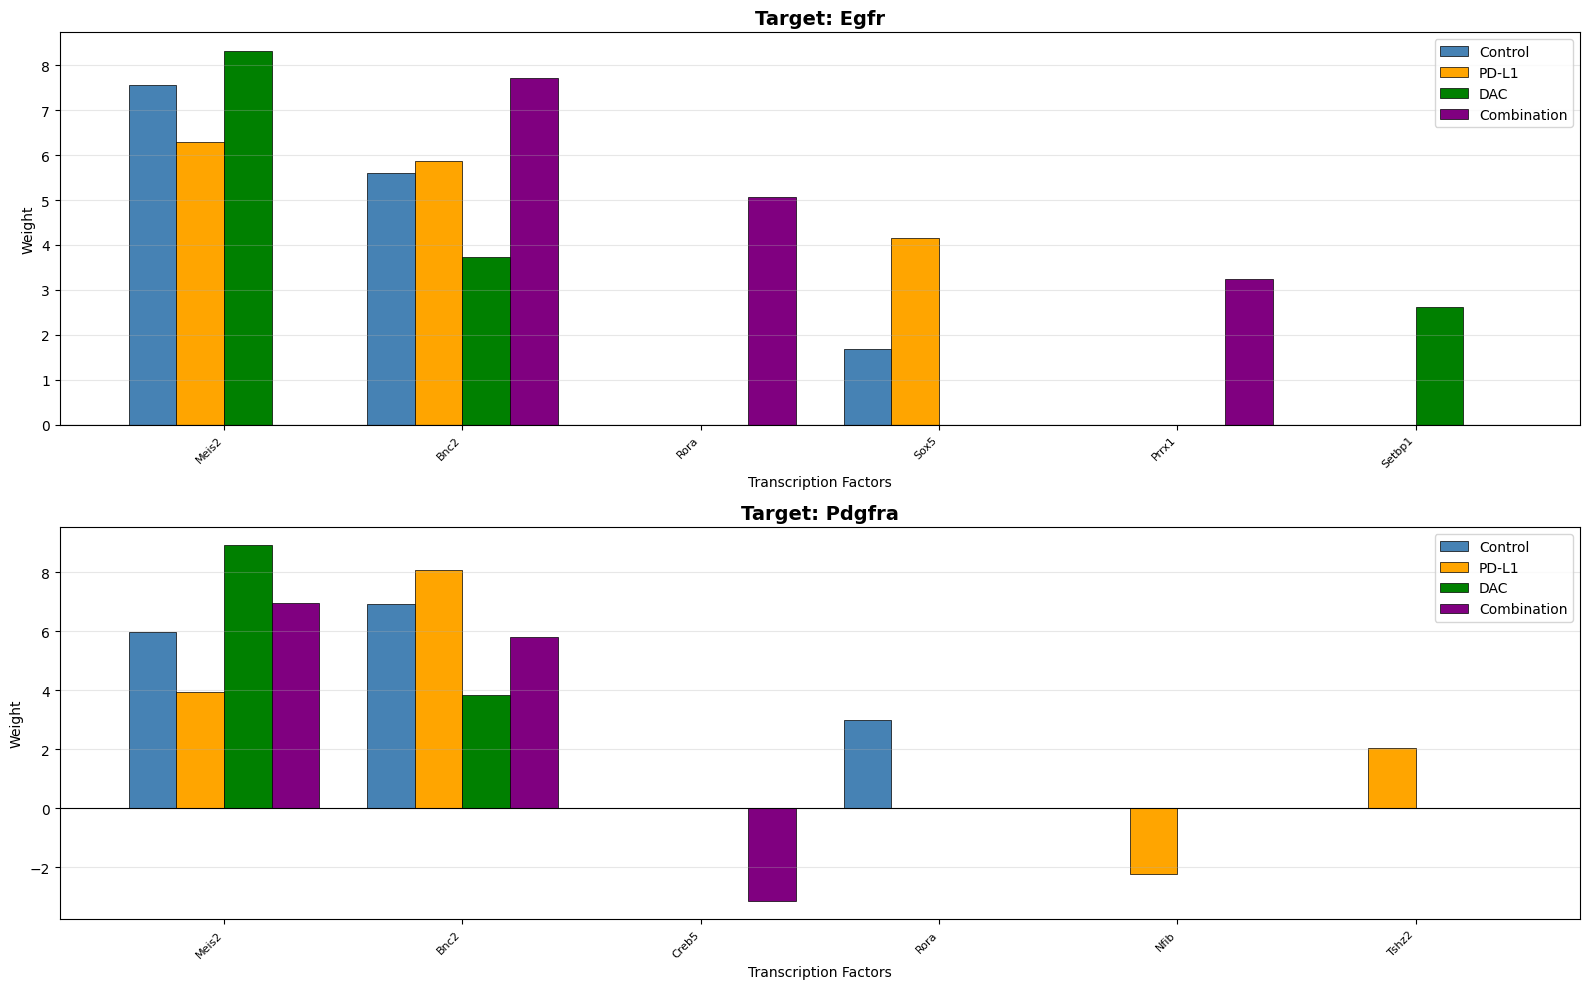

In [33]:
# Example target genes
target_genes = ['Egfr', 'Pdgfra']

# Plot target weights
fig = viz.plot_target_weights(
    target_names=target_genes,
    save=True
)
print("\nTarget weight barplots created successfully!")

### AUC Distribution Plots

Visualize TF activity score distributions across phenotypes with dissimilarity scores.


PLOTTING AUC DISTRIBUTIONS

Comparing labels [0, 1, 2, 3].
Processing Mef2c...
Processing Rora...
Processing Zeb1...
Processing Thrb...
✓ Saved to SimiCExampleRun/outputSimic/figures/experiment1/experiment1_AUC_distributions.pdf

AUC distribution plots created successfully!


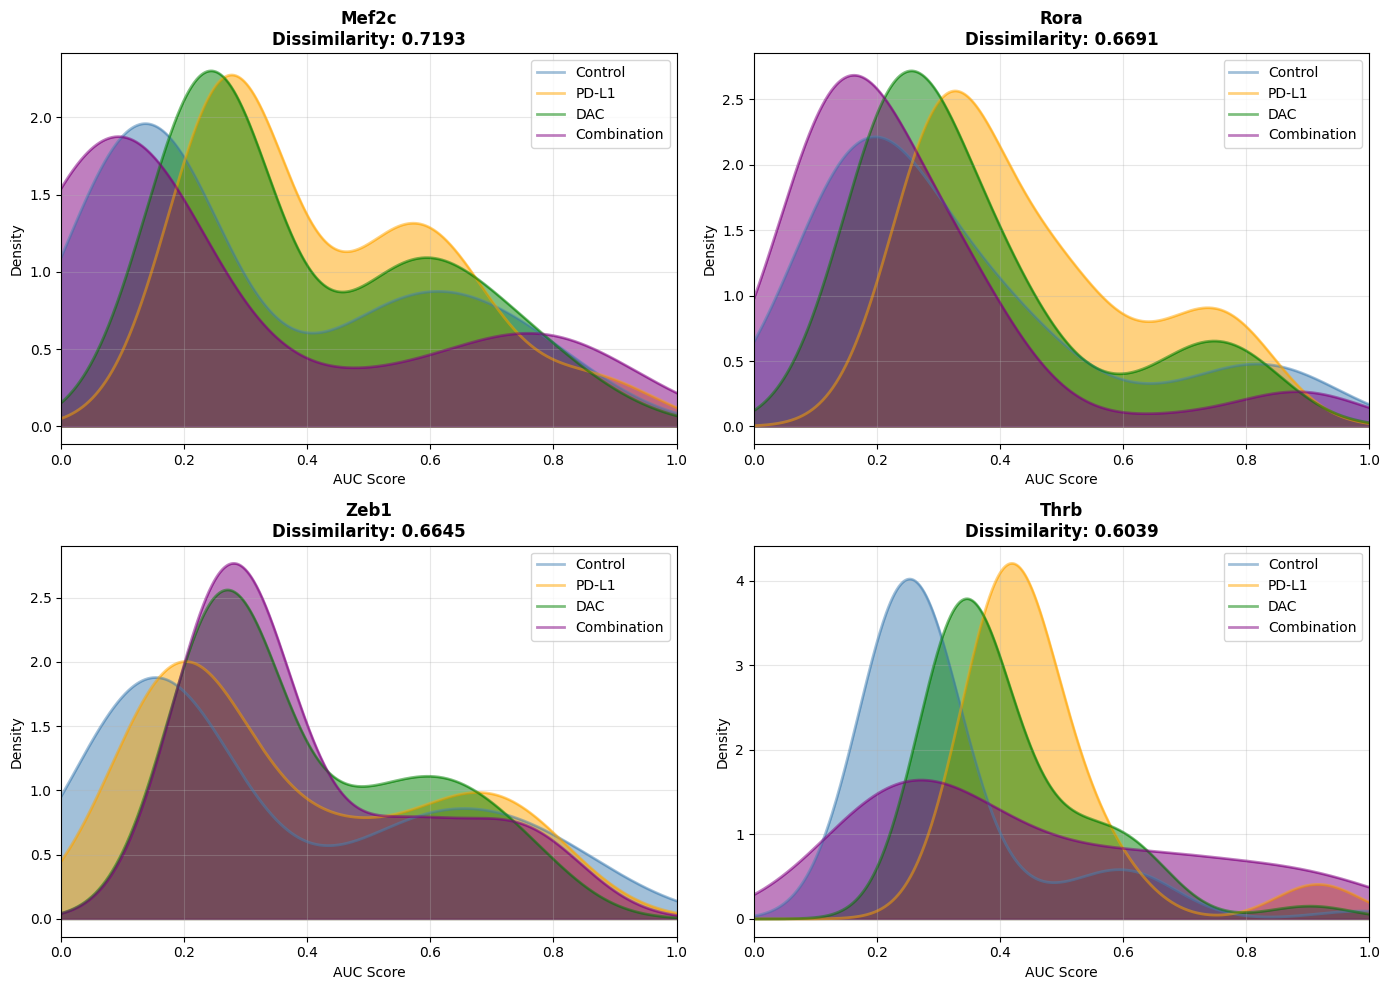

In [38]:
# Plot AUC distributions for top TFs
# With filled density curves
fig = viz.plot_auc_distributions(
    tf_names=top_tfs[:4],  # Use first 4 TFs for cleaner visualization
    labels=[0, 1, 2, 3],
    fill=True,
    alpha=0.5,
    bw_adjust=0.5,
    save=True
)
print("\nAUC distribution plots created successfully!")

### AUC Distribution Variations

Explore different visualization styles for AUC distributions.


PLOTTING AUC DISTRIBUTIONS

Comparing labels [0, 1, 2, 3].
Processing Mef2c...
Processing Rora...
✓ Saved to SimiCExampleRun/outputSimic/figures/experiment1/experiment1_AUC_distributions_light.pdf

Filled light and smooth AUC distributions created!


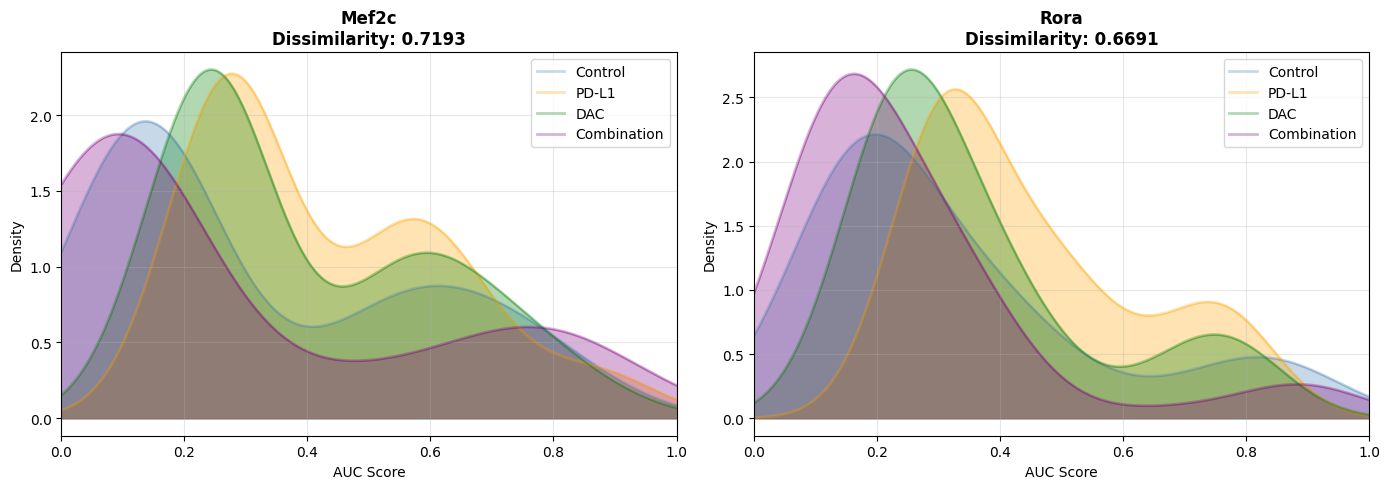

In [ ]:
# With smooth density and lighted fill
viz.plot_auc_distributions(
    tf_names=top_tfs[0:2], 
    labels=[0, 1, 2, 3], 
    fill=True,
    alpha=0.3, # Less intense colour
    bw_adjust=0.3,  # Less smooth - shows more detail
    filename=f"{pipeline.run_name}_AUC_distributions_light.pdf"
)
print("\nFilled light and smooth AUC distributions created!")


PLOTTING AUC DISTRIBUTIONS

Comparing labels [0, 3].
Processing Mef2c...
Processing Rora...
✓ Saved to SimiCExampleRun/outputSimic/figures/experiment1/experiment1_AUC_distributions_unfilled.pdf

Unfilled less smooth AUC distributions created!


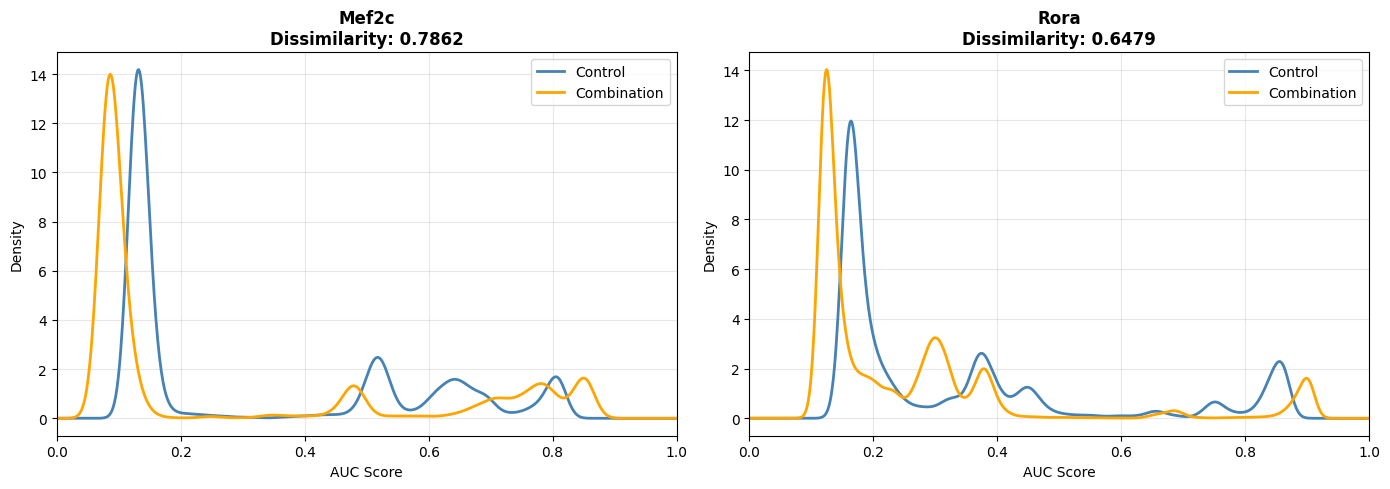

In [ ]:
# Without filled curves (line plot only) and less smooth density
viz.plot_auc_distributions(
    tf_names=top_tfs[0:2], 
    labels=[0, 3], 
    fill=False, # no fill
    bw_adjust= 0.05, # Less smooth - shows more detail
    filename=f"{pipeline.run_name}_AUC_distributions_unfilled.pdf"
)
print("\nUnfilled less smooth AUC distributions created!")

### Dissimilarity Heatmap

Visualize regulatory dissimilarity scores across all TFs.


PLOTTING DISSIMILARITY HEATMAP


CALCULATING DISSIMILARITY SCORES ACROSS LABELS

Comparing labels [0, 1, 2, 3].

Calculating dissimilarity scores...

Top 10 TFs by MinMax dissimilarity score:
  Mef2c: 0.7193
  Rora: 0.6691
  Zeb1: 0.6645
  Thrb: 0.6039
  Runx1: 0.5941
  Nfib: 0.5855
  Smad3: 0.5840
  Mitf: 0.5566
  Tshz2: 0.5456
  Nr6a1: 0.5179

Dissimilarity heatmap created successfully!


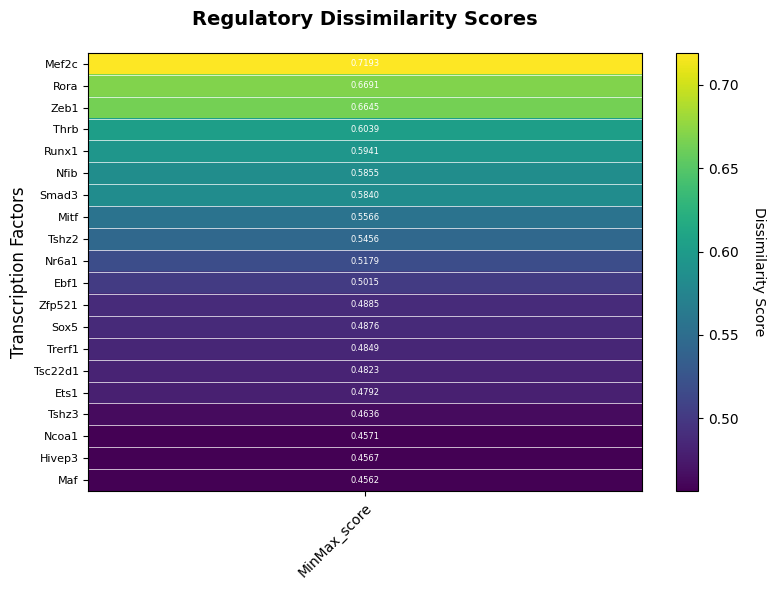

In [39]:
# Plot dissimilarity heatmap for top 20 TFs
fig = viz.plot_dissimilarity_heatmap(
    labels=[0, 1, 2, 3],
    top_n_tfs=20,
    save=False
)
print("\nDissimilarity heatmap created successfully!")

### Summary Statistics Visualization

Create a comprehensive view of AUC score distributions.

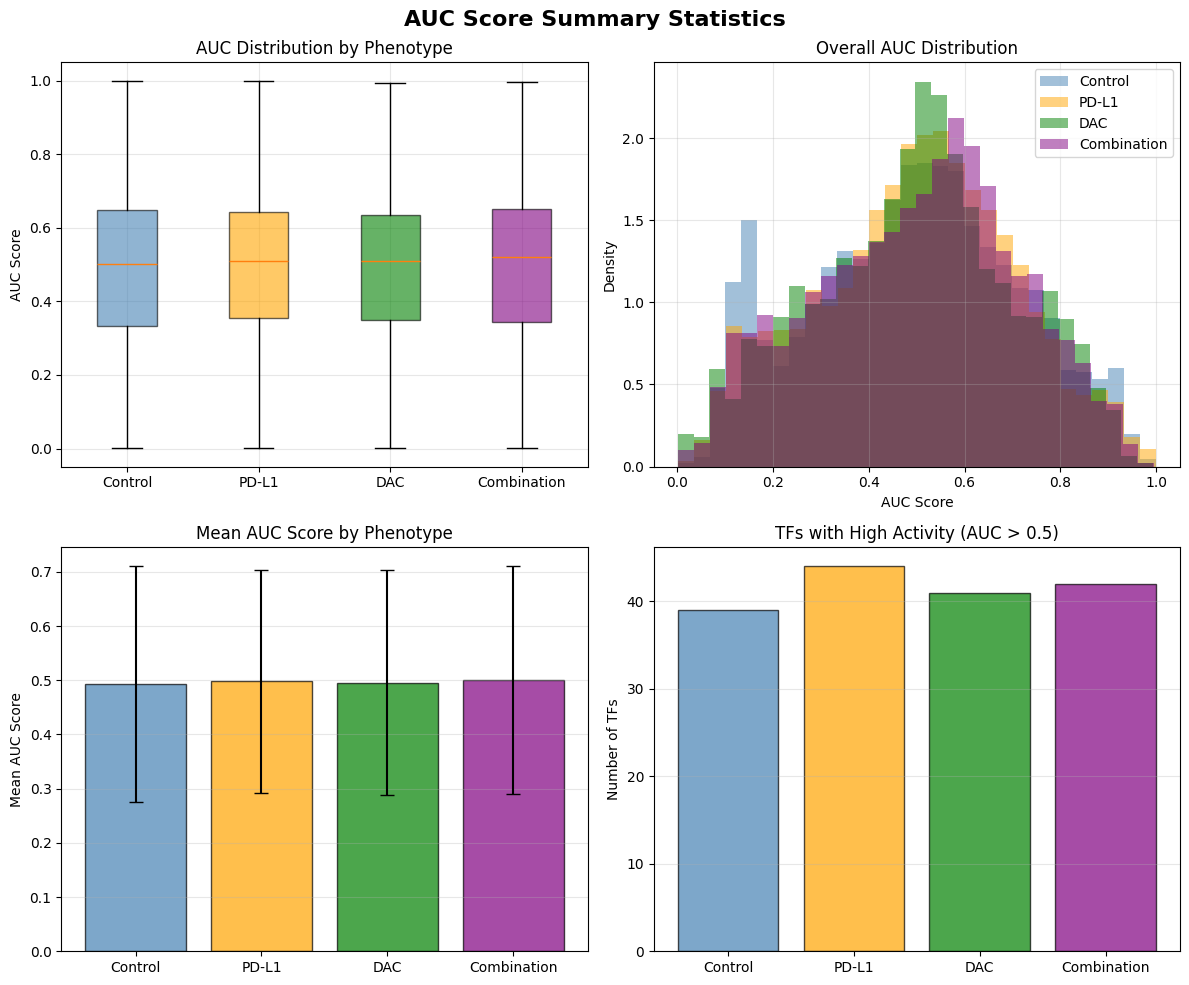


Summary statistics visualization created successfully!


In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Get AUC data for all labels
auc_filtered = pipeline.load_results('auc_filtered')

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('AUC Score Summary Statistics', fontsize=16, fontweight='bold')

colors = ['steelblue', 'orange', 'green', 'purple']
labels = [0, 1, 2, 3]
label_names = ['Control', 'PD-L1', 'DAC', 'Combination']

# 1. Box plot of AUC distributions
ax1 = axes[0, 0]
auc_data_list = []
for label in labels:
    auc_subset = pipeline.subset_label_specific_auc('auc_filtered', label)
    auc_values = auc_subset.values.flatten()
    auc_values = auc_values[~np.isnan(auc_values)]
    auc_data_list.append(auc_values)

bp = ax1.boxplot(auc_data_list, labels=label_names, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax1.set_ylabel('AUC Score', fontsize=10)
ax1.set_title('AUC Distribution by Phenotype', fontsize=12)
ax1.grid(alpha=0.3)

# 2. Histogram of overall AUC distribution
ax2 = axes[0, 1]
for idx, (label, label_name) in enumerate(zip(labels, label_names)):
    ax2.hist(auc_data_list[idx], bins=30, alpha=0.5, 
            color=colors[idx], label=label_name, density=True)
ax2.set_xlabel('AUC Score', fontsize=10)
ax2.set_ylabel('Density', fontsize=10)
ax2.set_title('Overall AUC Distribution', fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Mean AUC per label
ax3 = axes[1, 0]
mean_aucs = [np.mean(data) for data in auc_data_list]
std_aucs = [np.std(data) for data in auc_data_list]
x_pos = np.arange(len(labels))
ax3.bar(x_pos, mean_aucs, yerr=std_aucs, alpha=0.7, color=colors, 
       edgecolor='black', capsize=5)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(label_names)
ax3.set_ylabel('Mean AUC Score', fontsize=10)
ax3.set_title('Mean AUC Score by Phenotype', fontsize=12)
ax3.grid(alpha=0.3, axis='y')

# 4. Number of TFs with high activity (AUC > 0.5)
ax4 = axes[1, 1]
high_activity_counts = []
for label in labels:
    auc_subset = pipeline.subset_label_specific_auc('auc_filtered', label)
    # Count TFs with mean AUC > 0.5
    mean_auc_per_tf = auc_subset.mean(axis=0)
    high_activity = (mean_auc_per_tf > 0.5).sum()
    high_activity_counts.append(high_activity)

ax4.bar(x_pos, high_activity_counts, alpha=0.7, color=colors, edgecolor='black')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(label_names)
ax4.set_ylabel('Number of TFs', fontsize=10)
ax4.set_title('TFs with High Activity (AUC > 0.5)', fontsize=12)
ax4.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nSummary statistics visualization created successfully!")

### TF Network Visualization

Visualize the regulatory network for a specific TF across phenotypes.

Retrieving network for TF: Mef2c

Regulatory network for Mef2c:
Total targets: 87

Top 10 targets by absolute weight:


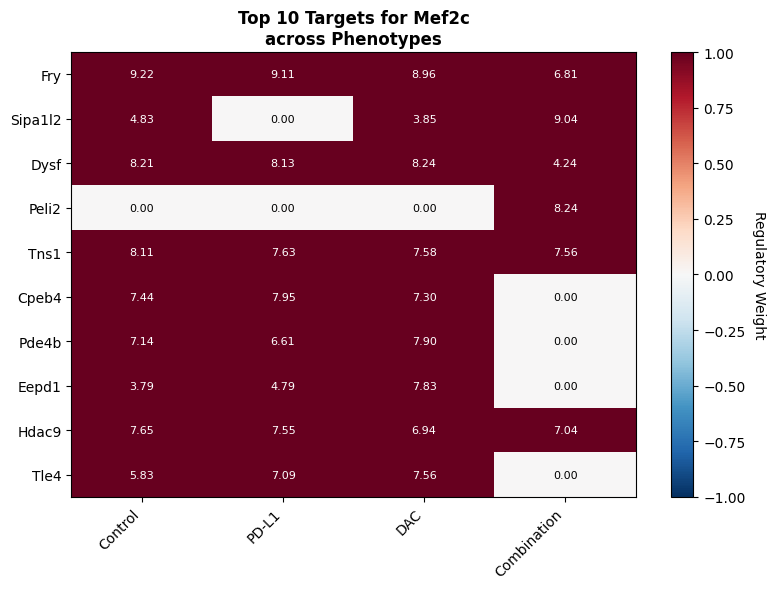


Network visualization for Mef2c created successfully!


In [41]:
# Get network for a specific TF
tf_of_interest = top_tfs[0]
network = pipeline.get_TF_network(tf_of_interest, stacked=True)

print(f"\nRegulatory network for {tf_of_interest}:")
print(f"Total targets: {len(network)}")
print(f"\nTop 10 targets by absolute weight:")

# Calculate max absolute weight across all phenotypes
network['max_abs_weight'] = network.abs().max(axis=1)
top_targets = network.nlargest(10, 'max_abs_weight')

# Plot heatmap of weights for top targets
fig, ax = plt.subplots(figsize=(8, 6))

# Drop the max_abs_weight column for plotting
plot_data = top_targets.drop('max_abs_weight', axis=1)

im = ax.imshow(plot_data.values, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)

# Set labels
ax.set_xticks(np.arange(len(plot_data.columns)))
ax.set_yticks(np.arange(len(plot_data.index)))
ax.set_xticklabels(label_names[:len(plot_data.columns)])
ax.set_yticklabels(plot_data.index)

# Rotate x labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Regulatory Weight', rotation=270, labelpad=15)

# Add title
ax.set_title(f'Top 10 Targets for {tf_of_interest}\nacross Phenotypes', 
            fontsize=12, fontweight='bold')

# Add values to cells
for i in range(len(plot_data.index)):
    for j in range(len(plot_data.columns)):
        text = ax.text(j, i, f'{plot_data.values[i, j]:.2f}',
                      ha='center', va='center', 
                      color='white' if abs(plot_data.values[i, j]) > 0.5 else 'black',
                      fontsize=8)

plt.tight_layout()
plt.show()

print(f"\nNetwork visualization for {tf_of_interest} created successfully!")

impor

In [43]:
# Basic usage with scanpy
import anndata as ad
adata = simicpipeline.load_from_anndata('./data/DAC_aPDL1_seurat_annotated.h5ad')
viz = SimiCVisualization(project_dir="path/to/dir", run_name="run1", adata=adata)
viz.plot_umap_with_activity(tf_names=["TF1", "TF2"])

# With custom scanpy parameters
viz.plot_umap_with_activity(
    tf_names=["TF1", "TF2", "TF3"],
    color_map='viridis',
    size=15,
    alpha=0.8,
    ncols=3,
    vmin=0,
    vmax=1
)

# Faceted plot by cell type
viz.plot_umap_with_activity_faceted(
    tf_names=["TF1"],
    facet_by="cell_type",
    color_map='plasma'
)

TypeError: SimiCPipeline.__init__() got an unexpected keyword argument 'adata'

### Cross-Validation Example

Run parameter sweep with cross-validation to automatically select optimal lambda1 and lambda2 values.

In [ ]:
def cross_validation_example():
    """
    Example with cross-validation for parameter selection.
    """
    cv_pipeline = SimiCPipeline(
        workdir="./SimiC_results/CV_experiment",
        run_name="cross_validation"
    )
    
    # Set paths
    cv_pipeline.set_paths(
        p2df=cv_pipeline.workdir / "inputFiles/data.pickle",
        p2assignment=cv_pipeline.workdir / "inputFiles/assignments.pickle",
        p2tf=cv_pipeline.workdir / "inputFiles/tfs.pickle"
    )
    
    # Enable cross-validation with parameter grid
    cv_pipeline.set_parameters(
        cross_val=True,
        list_of_l1=[10, 1, 1e-1, 1e-2, 1e-3],
        list_of_l2=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
    )
    
    # Run pipeline
    cv_pipeline.run_pipeline(
        skip_filtering=False,
        calculate_filtered_auc=True
    )
    
    return cv_pipeline

# Uncomment to run (warning: computationally intensive):
# cv_pipeline = cross_validation_example()

<div class="alert alert-block alert-warning">
<b>Warning:</b> Cross-validation with multiple lambda values is computationally intensive and may take several hours depending on data size and parameter grid complexity.
</div>

## Summary

This tutorial covered:

✓ Complete pipeline initialization with all parameters
✓ Running the full analysis with filtering and AUC calculation
✓ Loading and inspecting all result types
✓ Analyzing weights and AUC score distributions
✓ Calculating dissimilarity between cell populations
✓ Extracting TF-specific regulatory networks
✓ Creating informative visualizations
✓ Advanced configurations (custom paths, cross-validation)

## Next Steps

1. **Customize for your data**: Adjust file paths and parameters for your specific dataset
2. **Optimize parameters**: Use cross-validation to find optimal λ₁ and λ₂ values for your data
3. **Explore results**: Investigate specific TFs of interest and their predicted target networks
4. **Validate findings**: Compare inferred regulatory relationships with known literature or experimental data
5. **Visualize networks**: Create network diagrams for key TFs using network visualization tools

## Additional Resources

- For a simpler walkthrough, see `Tutorial_SimiCPipeline_simple.ipynb`
- Check example scripts: `5.2.2.SimiC_run_fullpipeline.py` and `5.2.3.SimiC_run_simple.py`
- Refer to the `SimiCPipeline` class documentation for detailed API information
- Read the original publication for algorithmic details and biological applications